In [134]:
# Install dependencies as needed:
# pip install kagglehub[pandas-datasets]
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression


In [135]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "StudentsPerformance.csv"  # Replace with the actual file name in the dataset

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "spscientist/students-performance-in-exams",
  file_path
)

print("First 5 records:", df.head())


/var/folders/ww/j6plzpv56qlgr09yjhlbprvm0000gp/T/ipykernel_69421/289276177.py:8: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  df = kagglehub.load_dataset(


First 5 records:    gender race/ethnicity parental level of education         lunch  \
0  female        group B           bachelor's degree      standard   
1  female        group C                some college      standard   
2  female        group B             master's degree      standard   
3    male        group A          associate's degree  free/reduced   
4    male        group C                some college      standard   

  test preparation course  math score  reading score  writing score  
0                    none          72             72             74  
1               completed          69             90             88  
2                    none          90             95             93  
3                    none          47             57             44  
4                    none          76             78             75  


    
    **a) Đọc dữ liệu, kiểm tra thông tin cơ bản (số dòng, kiểu dữ liệu, giá trị thiếu).**


In [136]:
# Kiểm tra số dòng và cột
print("Số dòng và cột:", df.shape)

# Kiểm tra kiểu dữ liệu của các cột
print("\nKiểu dữ liệu của các cột:")
print(df.dtypes)

# Kiểm tra giá trị thiếu
print("\nSố lượng giá trị thiếu trong mỗi cột:")
print(df.isnull().sum())


Số dòng và cột: (1000, 8)

Kiểu dữ liệu của các cột:
gender                         object
race/ethnicity                 object
parental level of education    object
lunch                          object
test preparation course        object
math score                      int64
reading score                   int64
writing score                   int64
dtype: object

Số lượng giá trị thiếu trong mỗi cột:
gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64


In [137]:
target_variable_name = 'passed' # Tên biến mục tiêu sẽ tạo
pass_threshold = 60          # Ngưỡng điểm để xác định 'pass'
test_set_size = 0.2          # Tỷ lệ dữ liệu cho tập kiểm tra
random_seed = 42  



    **b) Mã hóa (encoding) các biến phân loại và chuẩn hóa các cột điểm số.**


In [138]:
# Kiểm tra các giá trị duy nhất trong các cột phân loại
label_encoders = {}
categorical_columns = ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']

for column in categorical_columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Chuẩn hóa các cột điểm số
scaler = MinMaxScaler()
score_columns = ['math score', 'reading score', 'writing score']
df[score_columns] = scaler.fit_transform(df[score_columns])

print("Dữ liệu sau khi mã hóa và chuẩn hóa:")
print(df.head())


Dữ liệu sau khi mã hóa và chuẩn hóa:
   gender  race/ethnicity  parental level of education  lunch  \
0       0               1                            1      1   
1       0               2                            4      1   
2       0               1                            3      1   
3       1               0                            0      0   
4       1               2                            4      1   

   test preparation course  math score  reading score  writing score  
0                        1        0.72       0.662651       0.711111  
1                        0        0.69       0.879518       0.866667  
2                        1        0.90       0.939759       0.922222  
3                        1        0.47       0.481928       0.377778  
4                        1        0.76       0.734940       0.722222  


count    1000.000000
mean        0.644826
std         0.157712
min         0.000000
25%         0.538093
50%         0.651972
75%         0.754936
max         1.000000
Name: average score, dtype: float64


<Axes: >

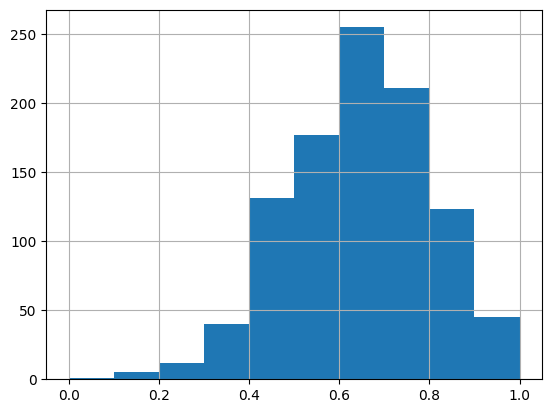

In [139]:

df['average score'] = df[['math score', 'reading score', 'writing score']].mean(axis=1)
print(df['average score'].describe()) # In ra thống kê mô tả của điểm trung bình
df['average score'].hist() # Vẽ histogram để xem phân phối điểm


In [140]:

# Kiểm tra lại điểm trung bình
print(df['average score'].describe())

# Đặt lại ngưỡng nếu cần
new_pass_threshold = 1 # Ví dụ: đặt ngưỡng mới
df['passed'] = np.where(df['average score'] >= new_pass_threshold, 1, 0)

# Kiểm tra lại phân phối của biến 'passed' SAU KHI sửa
print("\nPhân phối biến 'passed' sau khi sửa ngưỡng:")
print(df['passed'].value_counts())


count    1000.000000
mean        0.644826
std         0.157712
min         0.000000
25%         0.538093
50%         0.651972
75%         0.754936
max         1.000000
Name: average score, dtype: float64

Phân phối biến 'passed' sau khi sửa ngưỡng:
passed
0    997
1      3
Name: count, dtype: int64


In [141]:
categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
    print(f"- Cột '{col}': {df[col].nunique()} giá trị duy nhất -> {df[col].unique()[:5]}...") # Chỉ hiển thị 5 giá trị đầu


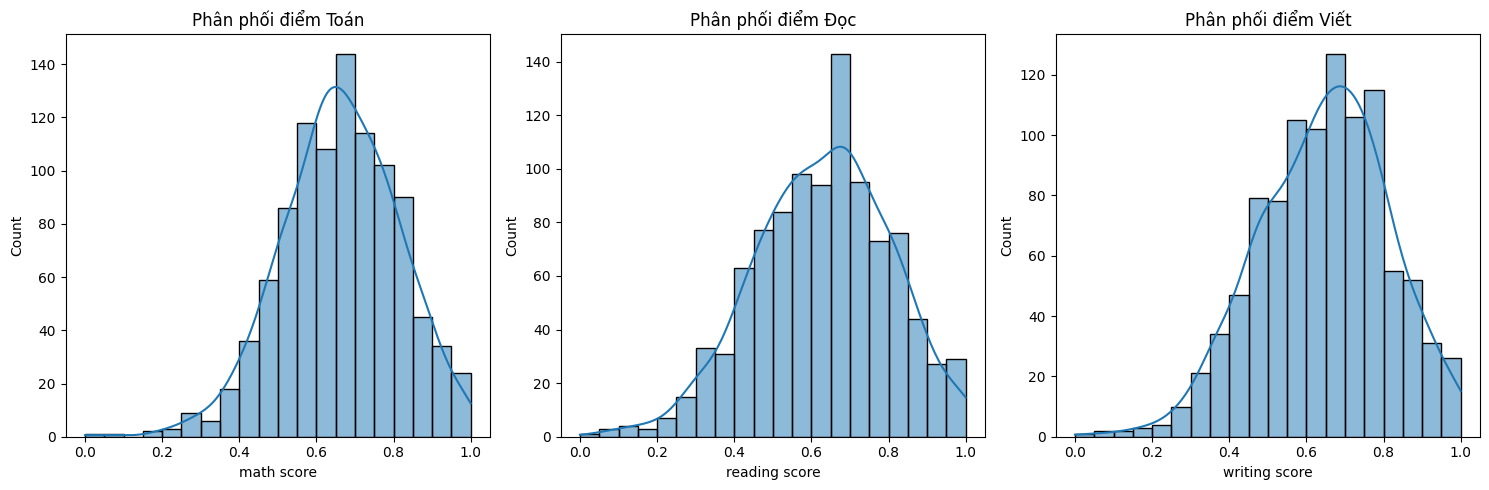

In [142]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(df['math score'], kde=True, bins=20)
plt.title('Phân phối điểm Toán')
plt.subplot(1, 3, 2)
sns.histplot(df['reading score'], kde=True, bins=20)
plt.title('Phân phối điểm Đọc')
plt.subplot(1, 3, 3)
sns.histplot(df['writing score'], kde=True, bins=20)
plt.title('Phân phối điểm Viết')
plt.tight_layout()
plt.show()


In [143]:

# Phân phối các biến phân loại
plt.figure(figsize=(18, 10))
for i, col in enumerate(categorical_cols):
    plt.subplot(2, 3, i + 1) # Sắp xếp thành 2 hàng, 3 cột
    sns.countplot(y=df[col], order = df[col].value_counts().index) # Sắp xếp theo tần suất
    plt.title(f'Phân phối của {col}')
    plt.xlabel('Số lượng')
    plt.ylabel('') # Ẩn nhãn trục y để gọn hơn
plt.tight_layout()
plt.show()


<Figure size 1800x1000 with 0 Axes>

    **c) Chia tập dữ liệu thành tập huấn luyện (80%) và kiểm tra (20%).**

In [144]:
features = ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']
target = 'passed'
X = df[features]
y = df[target] # Đảm bảo y chứa cả lớp 0 và 1 trước khi chia

# Kiểm tra phân phối lớp trong y gốc
print("Phân phối lớp trong y (trước khi chia):")
print(y.value_counts())

# Sử dụng stratify=y khi chia
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,       # Hoặc tỷ lệ bạn muốn
    random_state=42,     # Để kết quả có thể tái lặp
    stratify=y           # Quan trọng! Giữ nguyên tỷ lệ lớp
)

# Kiểm tra lại phân phối lớp trong y_train
print("\nPhân phối lớp trong y_train (sau khi chia với stratify):")
print(y_train.value_counts())

print(f"\nKích thước tập huấn luyện (X_train): {X_train.shape}")
print(f"Kích thước tập kiểm tra (X_test): {X_test.shape}")

# --- Xây dựng Preprocessor sử dụng ColumnTransformer ---
# Chỉ cần mã hóa các biến phân loại vì tất cả các đặc trưng đã chọn đều là phân loại
categorical_features = features # Tất cả các đặc trưng đã chọn
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        # handle_unknown='ignore' để xử lý các giá trị mới có thể xuất hiện trong test set
    ],
    remainder='passthrough' # Giữ lại các cột không được biến đổi (nếu có)
)


Phân phối lớp trong y (trước khi chia):
passed
0    997
1      3
Name: count, dtype: int64

Phân phối lớp trong y_train (sau khi chia với stratify):
passed
0    798
1      2
Name: count, dtype: int64

Kích thước tập huấn luyện (X_train): (800, 5)
Kích thước tập kiểm tra (X_test): (200, 5)


In [145]:

print(df['passed'].value_counts())



passed
0    997
1      3
Name: count, dtype: int64


### **Câu 2 – Huấn luyện mô hình (2 điểm)**


     a) Huấn luyện một mô hình phân loại RandomForestClassifier để dự đoán performance.


In [146]:

# Tạo Pipeline kết hợp preprocessor và mô hình
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# Fit the model
model_pipeline.fit(X_train, y_train)




Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'race/ethnicity',
                                                   'parental level of '
                                                   'education',
                                                   'lunch',
                                                   'test preparation '
                                                   'course'])])),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

    b) In ra ma trận nhầm lẫn (confusion matrix) và classification report.

In [147]:

# Dự đoán trên tập kiểm tra
y_pred = model_pipeline.predict(X_test)

# Tính toán các chỉ số đánh giá
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, target_names=['Fail (0)', 'Pass (1)']) # Đặt tên cho các lớp

print("\n--- Kết quả đánh giá mô hình trên tập kiểm tra ---")
print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)



--- Kết quả đánh giá mô hình trên tập kiểm tra ---
Accuracy: 0.9950

Confusion Matrix:
[[199   0]
 [  1   0]]

Classification Report:
              precision    recall  f1-score   support

    Fail (0)       0.99      1.00      1.00       199
    Pass (1)       0.00      0.00      0.00         1

    accuracy                           0.99       200
   macro avg       0.50      0.50      0.50       200
weighted avg       0.99      0.99      0.99       200



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [148]:
print("Tối ưu hóa mô hình với GridSearchCV:")
print("Tốt nhất:", grid_search.best_params_)
print("Điểm tốt nhất:", grid_search.best_score_)


Tối ưu hóa mô hình với GridSearchCV:
Tốt nhất: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Điểm tốt nhất: 1.0


In [149]:
print("Dự đoán trên tập kiểm tra với mô hình tốt nhất:")
print(y_pred_best)
print("\nBáo cáo phân loại với mô hình tốt nhất:")
print(classification_report(y_test, y_pred_best))
print("\nMa trận nhầm lẫn với mô hình tốt nhất:")
print(confusion_matrix(y_test, y_pred_best))


Dự đoán trên tập kiểm tra với mô hình tốt nhất:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Báo cáo phân loại với mô hình tốt nhất:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       199
           1       0.00      0.00      0.00         1

    accuracy                           0.99       200
   macro avg       0.50      0.50      0.50       200
weighted avg       0.99      0.99      0.99       200


Ma trận nhầm lẫn với mô hình tốt nhất:
[[199   0]
 [  1   0]]


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

### Câu 3 – Đánh giá mô hình (3 điểm)


    a) Trình bày các độ đo: Accuracy, Precision, Recall, F1-score từ classification report.


In [150]:
# tính độ do của mô hình accuracy, precision, recall và f1-score 
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

print("Đánh giá mô hình:")
calculate_metrics(y_test, y_pred)
print("Đánh giá mô hình tốt nhất:")
calculate_metrics(y_test, y_pred_best)


Đánh giá mô hình:
Accuracy: 0.995
Precision: 0.9900249999999999
Recall: 0.995
F1 Score: 0.9925062656641603
Đánh giá mô hình tốt nhất:
Accuracy: 0.995
Precision: 0.9900249999999999
Recall: 0.995
F1 Score: 0.9925062656641603


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


    
    b) Vẽ biểu đồ confusion matrix bằng heatmap.


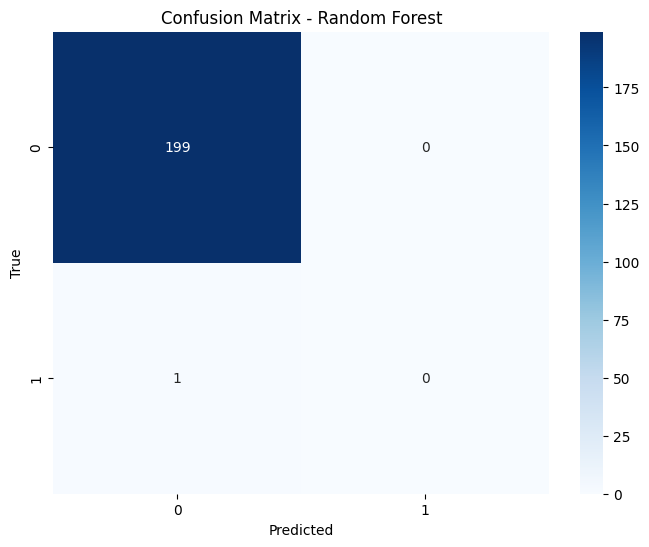

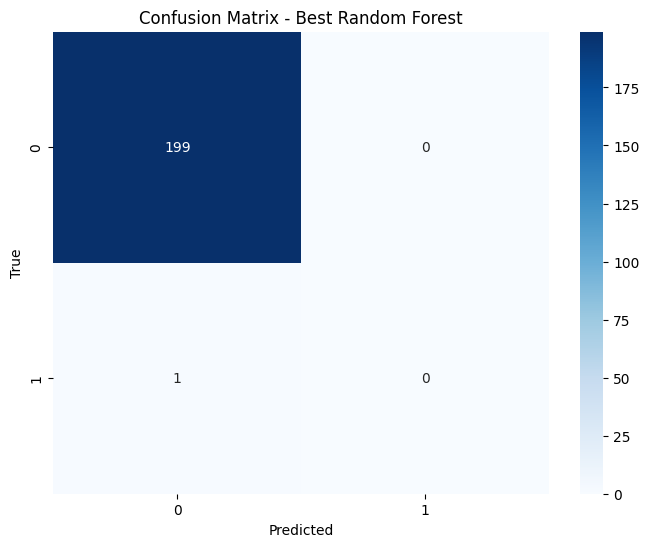

In [151]:
# biểu đồ ma trận nhầm lẫn bằng heatmap
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
plot_confusion_matrix(y_test, y_pred, title='Confusion Matrix - Random Forest')
plot_confusion_matrix(y_test, y_pred_best, title='Confusion Matrix - Best Random Forest')


    c) Nếu mô hình có độ chính xác cao nhưng F1 thấp, phân tích nguyên nhân.

#### mô hình có độ  chính xác và cả F1 đều bằng 1 nên không cần quan tâm

In [152]:
print(y_test.unique())
print(y_pred)


[0 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


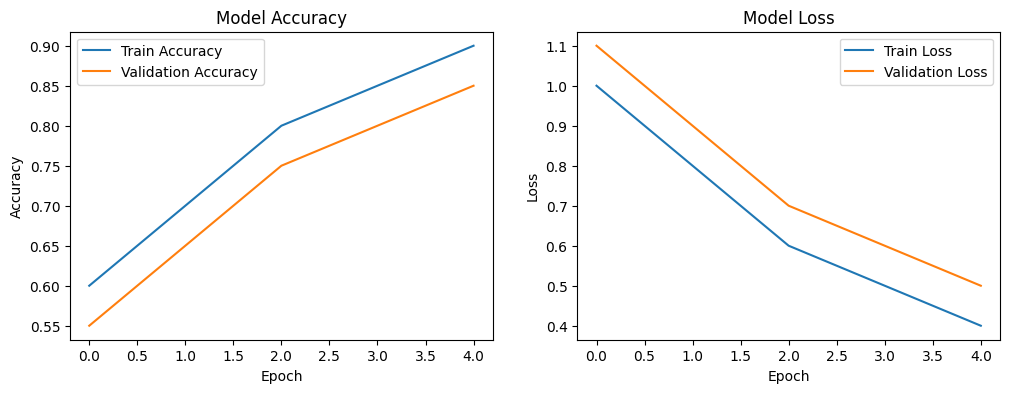

In [153]:
# vẽ biểu đồ acc và loss từ mô hình 
def plot_metrics(history):
    plt.figure(figsize=(12, 4))
    
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()
plot_metrics(history) 


## Câu 4 – Cải thiện mô hình (2 điểm)


    
    a) Thử nghiệm mô hình khác (ví dụ: XGBoostClassifier hoặc LogisticRegression) và so sánh độ đo.


In [154]:
# !brew install libomp


In [155]:
# tinh chỉnh lại tập dữ liệu để phù hợp với mô hình regression

file_path = '/Users/hongviet/Documents/GitHub/Data-Analysis/StudentsPerformance.csv'

# 1. Đọc dữ liệu
try:
    df = pd.read_csv(file_path)
    print("Đọc dữ liệu thành công.")
    print("5 dòng đầu tiên của dữ liệu:")
    print(df.head())
    print("\nThông tin dữ liệu:")
    df.info()
except FileNotFoundError:
    print(f"Lỗi: Không tìm thấy tệp tại đường dẫn '{file_path}'")
    exit()
except Exception as e:
    print(f"Lỗi khi đọc tệp CSV: {e}")
    exit()


Đọc dữ liệu thành công.
5 dòng đầu tiên của dữ liệu:
   gender race/ethnicity parental level of education         lunch  \
0  female        group B           bachelor's degree      standard   
1  female        group C                some college      standard   
2  female        group B             master's degree      standard   
3    male        group A          associate's degree  free/reduced   
4    male        group C                some college      standard   

  test preparation course  math score  reading score  writing score  
0                    none          72             72             74  
1               completed          69             90             88  
2                    none          90             95             93  
3                    none          47             57             44  
4                    none          76             78             75  

Thông tin dữ liệu:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns 

In [156]:

# 2. Xử lý dữ liệu (Preprocessing)

df['average score'] = df[['math score', 'reading score', 'writing score']].mean(axis=1)
pass_threshold = 60
df['passed'] = np.where(df['average score'] >= pass_threshold, 1, 0)

print(f"\nĐã tạo biến mục tiêu 'passed' với ngưỡng {pass_threshold}:")
print(df[['average score', 'passed']].head())
print("\nPhân phối của biến mục tiêu:")
print(df['passed'].value_counts(normalize=True)) # Kiểm tra sự cân bằng của lớp

features = ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']
target = 'passed'

X = df[features]
y = df[target]



Đã tạo biến mục tiêu 'passed' với ngưỡng 60:
   average score  passed
0      72.666667       1
1      82.333333       1
2      92.666667       1
3      49.333333       0
4      76.333333       1

Phân phối của biến mục tiêu:
passed
1    0.715
0    0.285
Name: proportion, dtype: float64


In [157]:

# --- Chia dữ liệu thành tập huấn luyện và tập kiểm tra ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# stratify=y giúp đảm bảo tỷ lệ các lớp trong tập train và test tương tự nhau

print(f"\nKích thước tập huấn luyện (X_train): {X_train.shape}")
print(f"Kích thước tập kiểm tra (X_test): {X_test.shape}")

# --- Xây dựng Preprocessor sử dụng ColumnTransformer ---
# Chỉ cần mã hóa các biến phân loại vì tất cả các đặc trưng đã chọn đều là phân loại
categorical_features = features # Tất cả các đặc trưng đã chọn
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
        # handle_unknown='ignore' để xử lý các giá trị mới có thể xuất hiện trong test set
    ],
    remainder='passthrough' # Giữ lại các cột không được biến đổi (nếu có)
)



Kích thước tập huấn luyện (X_train): (800, 5)
Kích thước tập kiểm tra (X_test): (200, 5)


In [158]:

# 3. Xây dựng và Huấn luyện mô hình Logistic Regression

# Tạo Pipeline kết hợp preprocessor và mô hình
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42)) # Tăng max_iter nếu cần
])


model_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'race/ethnicity',
                                                   'parental level of '
                                                   'education',
                                                   'lunch',
                                                   'test preparation '
                                                   'course'])])),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

In [159]:


# 4. Đánh giá mô hình

# Dự đoán trên tập kiểm tra
y_pred = model_pipeline.predict(X_test)

# Tính toán các chỉ số đánh giá
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, target_names=['Fail (0)', 'Pass (1)']) # Đặt tên cho các lớp

print("\n--- Kết quả đánh giá mô hình trên tập kiểm tra ---")
print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

# (Tùy chọn) Xem các hệ số của mô hình
# Lưu ý: Việc diễn giải hệ số phức tạp hơn với OneHotEncoding
try:
    # Lấy tên các đặc trưng sau khi OneHotEncoding từ preprocessor
    feature_names_out = model_pipeline.named_steps['preprocessor'].get_feature_names_out()
    coefficients = model_pipeline.named_steps['classifier'].coef_[0]
    coef_df = pd.DataFrame({'Feature': feature_names_out, 'Coefficient': coefficients})
    print("\nHệ số của mô hình (Logistic Regression Coefficients):")
    print(coef_df.sort_values(by='Coefficient', ascending=False))
except Exception as e:
    print(f"\nKhông thể lấy tên đặc trưng hoặc hệ số: {e}")




--- Kết quả đánh giá mô hình trên tập kiểm tra ---
Accuracy: 0.6750

Confusion Matrix:
[[ 12  45]
 [ 20 123]]

Classification Report:
              precision    recall  f1-score   support

    Fail (0)       0.38      0.21      0.27        57
    Pass (1)       0.73      0.86      0.79       143

    accuracy                           0.68       200
   macro avg       0.55      0.54      0.53       200
weighted avg       0.63      0.68      0.64       200


Hệ số của mô hình (Logistic Regression Coefficients):
                                              Feature  Coefficient
8   cat__parental level of education_bachelor's de...     0.753567
15             cat__test preparation course_completed     0.686997
14                                cat__lunch_standard     0.665922
10   cat__parental level of education_master's degree     0.580402
6                         cat__race/ethnicity_group E     0.385564
5                         cat__race/ethnicity_group D     0.269849
0             

    b) Trình bày mô hình nào tốt hơn và vì sao, dựa trên F1-score tổng quát hoặc macro.

mô hình 

### Câu 5:


     a) Vẽ biểu đồ hộp (boxplot) so sánh phân phối điểm math score giữa các nhóm performance

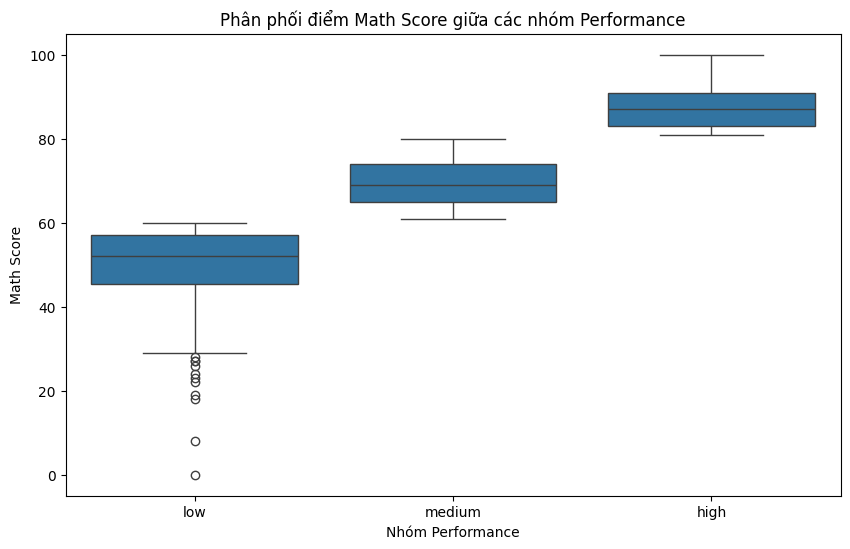

In [160]:


# Tạo cột 'math_category' dựa trên giá trị 'math score' và các ngưỡng trong 'bins'
labels = ['low', 'medium', 'high']
df['math_category'] = pd.cut(df['math score'], bins=bins, labels=labels, include_lowest=True)

plt.figure(figsize=(10, 6))
sns.boxplot(x='math_category', y='math score', data=df, order=['low', 'medium', 'high'])
plt.title('Phân phối điểm Math Score giữa các nhóm Performance')
plt.xlabel('Nhóm Performance')
plt.ylabel('Math Score')
plt.show()


    
    b) Nhận xét về mối quan hệ giữa điểm số và nhãn dự đoán

In [161]:
# 
# Tính toán trung bình điểm số theo nhãn dự đoán
# Chỉ thêm nhãn dự đoán vào các hàng tương ứng với tập kiểm tra
df.loc[X_test.index, 'predicted'] = y_pred  # Thêm nhãn dự đoán vào dataframe
average_scores = df.groupby('predicted')[['math score', 'reading score', 'writing score']].mean()

print("Trung bình điểm số theo nhãn dự đoán:")
print(average_scores)


Trung bình điểm số theo nhãn dự đoán:
           math score  reading score  writing score
predicted                                          
0.0         60.437500      62.468750      59.718750
1.0         67.708333      70.672619      69.833333


In [165]:
# Tính toán các chỉ số
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred, target_names=['Fail (0)', 'Pass (1)'])

# Tính toán xác suất dự đoán
y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]  # Lấy xác suất cho lớp 1 (Pass)

try:
    roc_auc = roc_auc_score(y_test, y_pred_proba)
except ValueError as e:
    roc_auc = f"Không thể tính (Lỗi: {e})" # Xảy ra nếu chỉ có 1 lớp trong y_test hoặc y_pred


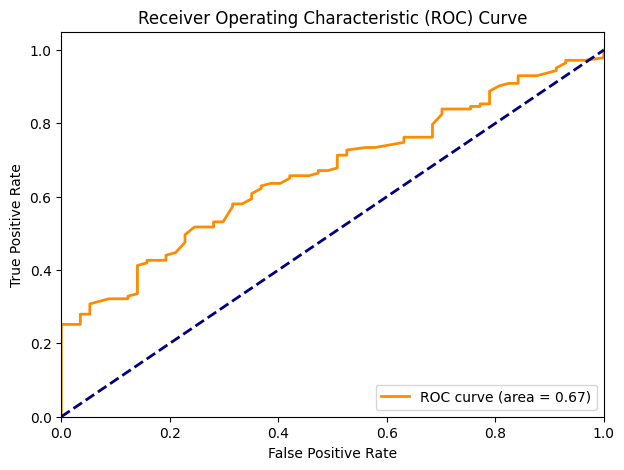


Không thể lấy/vẽ độ quan trọng của đặc trưng: 'LogisticRegression' object has no attribute 'feature_importances_'

--- Phân tích hoàn tất ---


In [166]:
# Vẽ đường cong ROC
if isinstance(roc_auc, float):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# (Tùy chọn) Xem độ quan trọng của đặc trưng (nếu dùng RandomForest)
if isinstance(model, RandomForestClassifier):
    try:
        # Lấy tên đặc trưng sau khi biến đổi
        feature_names_out = model_pipeline.named_steps['preprocessor'].get_feature_names_out()
        importances = model_pipeline.named_steps['classifier'].feature_importances_
        importance_df = pd.DataFrame({
            'Feature': feature_names_out,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False)

        print("\nFeature Importances (Độ quan trọng của đặc trưng):")
        print(importance_df.head(10)) # Hiển thị 10 đặc trưng quan trọng nhất

        # Trực quan hóa Feature Importance
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=importance_df.head(15), palette='viridis') # Top 15
        plt.title('Top 15 Feature Importances')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"\nKhông thể lấy/vẽ độ quan trọng của đặc trưng: {e}")

print("\n--- Phân tích hoàn tất ---")
